In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Install necessary libraries
!pip install -q tensorflow keras torch torchvision transformers

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Set dataset path
DATASET_PATH = '/kaggle/input/deep-fashion-multimodal'


In [2]:
# Set dataset path
DATASET_PATH = '/kaggle/input/deep-fashion-multimodal'

# Section 1: Dataset Exploration
print("Dataset Directories:", os.listdir(DATASET_PATH))

# Check the structure of the dataset
for subdir, dirs, files in os.walk(DATASET_PATH):
    print(f"{subdir}: {len(files)} files")
    break  # Only checking the first level

Dataset Directories: ['selected_images', 'labels_front.csv', 'labels_front.feather']
/kaggle/input/deep-fashion-multimodal: 2 files


In [3]:
# Install necessary libraries
!pip install -q tensorflow keras torch torchvision transformers pandas feather-format

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image

# Set dataset path
DATASET_PATH = '/kaggle/input/deep-fashion-multimodal'
IMAGE_FOLDER = os.path.join(DATASET_PATH, 'selected_images')
CSV_PATH = os.path.join(DATASET_PATH, 'labels_front.csv')
FEATHER_PATH = os.path.join(DATASET_PATH, 'labels_front.feather')

  Preparing metadata (setup.py) ... done


In [4]:
# Section 1: Load Labels
if os.path.exists(CSV_PATH):
    labels_df = pd.read_csv(CSV_PATH)
    print("CSV Labels Loaded:")
    print(labels_df.head())
elif os.path.exists(FEATHER_PATH):
    labels_df = pd.read_feather(FEATHER_PATH)
    print("Feather Labels Loaded:")
    print(labels_df.head())
else:
    raise FileNotFoundError("No label file found!")

# Ensure dataset has the necessary columns (modify column names as needed)
print("Columns in Label File:", labels_df.columns)

CSV Labels Loaded:
                           image_id  \
0  MEN-Denim-id_00000089-28_1_front   
1  MEN-Denim-id_00000265-01_1_front   
2  MEN-Denim-id_00000313-01_1_front   
3  MEN-Denim-id_00000516-01_1_front   
4  MEN-Denim-id_00000750-01_1_front   

                                             caption  \
0  This gentleman is wearing a medium-sleeve shir...   
1  This person is wearing a short-sleeve shirt wi...   
2  The gentleman is wearing a short-sleeve T-shir...   
3  The person wears a sleeveless tank shirt with ...   
4  His sweater has long sleeves, cotton fabric an...   

                                   path gender product_type   product_id  \
0  MEN-Denim-id_00000089-28_1_front.jpg    MEN        Denim  id_00000089   
1  MEN-Denim-id_00000265-01_1_front.jpg    MEN        Denim  id_00000265   
2  MEN-Denim-id_00000313-01_1_front.jpg    MEN        Denim  id_00000313   
3  MEN-Denim-id_00000516-01_1_front.jpg    MEN        Denim  id_00000516   
4  MEN-Denim-id_00000750-01_1

In [5]:
# Section 2: Verify Image-Label Mapping
# Ensure dataset has the necessary columns
print("Columns in Label File:", labels_df.columns)

# Extract the correct column name for image filenames
image_column = 'path'  # Change this if the actual column is different

# Verify Image-Label Mapping
image_filenames = set(os.listdir(IMAGE_FOLDER))
labels_df['has_image'] = labels_df[image_column].apply(lambda x: x in image_filenames)

# Remove missing images from dataset
clean_labels_df = labels_df[labels_df['has_image']].drop(columns=['has_image'])
print(f"Total images available: {len(image_filenames)}, Total labeled images: {len(clean_labels_df)}")


Columns in Label File: Index(['image_id', 'caption', 'path', 'gender', 'product_type', 'product_id',
       'image_type'],
      dtype='object')
Total images available: 12278, Total labeled images: 12278


In [ ]:
# Section 3: Custom Dataset Class
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image)

class FashionDataset(Dataset):
    def __init__(self, labels_df, image_folder, transform=None):
        self.labels_df = labels_df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx]['image_name']
        label = self.labels_df.iloc[idx]['label']  # Adjust based on dataset
        img_path = os.path.join(self.image_folder, img_name)
        image = preprocess_image(img_path)
        return image, label

In [ ]:
# Section 3: Custom Dataset Class
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image)

class FashionDataset(Dataset):
    def __init__(self, labels_df, image_folder, transform=None):
        self.labels_df = labels_df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx]['path']  # Adjust column name if needed
        label = self.labels_df.iloc[idx]['label']
        img_path = os.path.join(self.image_folder, img_name)
        image = preprocess_image(img_path)
        return image, label

# Ensure dataset is loaded
try:
    dataset = FashionDataset(clean_labels_df, IMAGE_FOLDER)
    print(f"Dataset Loaded: {len(dataset)} samples available")
except Exception as e:
    print("Error loading dataset:", str(e))


In [6]:
# Section 3: Custom Dataset Class
# Define label column
label_column = 'product_type'  # Change to 'gender' or 'product_id' if needed

# Ensure the label column exists
if label_column not in clean_labels_df.columns:
    raise KeyError(f"Column '{label_column}' not found in dataset. Available columns: {clean_labels_df.columns}")

# Convert labels to categorical and encode them as numerical values
clean_labels_df[label_column] = clean_labels_df[label_column].astype('category')
label_mapping = {category: idx for idx, category in enumerate(clean_labels_df[label_column].cat.categories)}
clean_labels_df['encoded_label'] = clean_labels_df[label_column].map(label_mapping)

print("Label Mapping:", label_mapping)  # Debugging: Show label encoding

# Define preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    image = Image.open(image_path).convert("RGB")
    return transform(image)

# Define Custom Dataset Class
class FashionDataset(Dataset):
    def __init__(self, labels_df, image_folder, transform=None):
        self.labels_df = labels_df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx]['path']  # Image filename
        label = self.labels_df.iloc[idx]['encoded_label']  # Encoded label
        img_path = os.path.join(self.image_folder, img_name)

        if not os.path.exists(img_path):
            print(f"Warning: Image {img_path} not found!")  # Debugging
            return None  # Skip missing images

        image = preprocess_image(img_path)
        return image, label

# Instantiate dataset
dataset = FashionDataset(clean_labels_df, IMAGE_FOLDER)
print(f"Dataset Loaded: {len(dataset)} samples")


Label Mapping: {'Blouses_Shirts': 0, 'Cardigans': 1, 'Denim': 2, 'Dresses': 3, 'Graphic_Tees': 4, 'Jackets_Coats': 5, 'Jackets_Vests': 6, 'Leggings': 7, 'Pants': 8, 'Rompers_Jumpsuits': 9, 'Shirts_Polos': 10, 'Shorts': 11, 'Skirts': 12, 'Suiting': 13, 'Sweaters': 14, 'Sweatshirts_Hoodies': 15, 'Tees_Tanks': 16}
Dataset Loaded: 12278 samples


In [7]:
# Section 4: Split Dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Dataset split: Train:", len(train_dataset), "Validation:", len(val_dataset), "Test:", len(test_dataset))

Dataset split: Train: 8594 Validation: 1841 Test: 1843


In [8]:
# Section 4: Split Dataset
# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

print("Dataset split sizes - Train:", len(train_dataset), "Validation:", len(val_dataset), "Test:", len(test_dataset))


Dataset split sizes - Train: 8594 Validation: 1841 Test: 1843


In [ ]:
# Section 5: Sample Data Visualization
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print("Labels:", labels[:4].tolist())

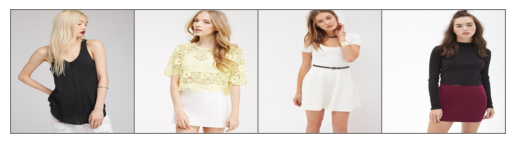

Sample Labels: [16, 0, 3, 12]


In [9]:
# Section 5: Sample Data Visualization
import torchvision  # Ensure torchvision is imported

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")  # Hide axes
    plt.show()

# Fetch a sample batch
dataiter = iter(train_loader)
sample_images, sample_labels = next(dataiter)  # Correctly unpack batch

# Show sample images
imshow(torchvision.utils.make_grid(sample_images[:4]))  # Show first 4 images
print("Sample Labels:", sample_labels[:4].tolist())  # Print first 4 labels


In [10]:
# Section 6: Advanced Models - Transfer Learning & Attention Mechanism
# Import necessary Keras layers
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define available models
models_list = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "MobileNetV2": MobileNetV2,
    "DenseNet121": DenseNet121,
    "EfficientNetB0": EfficientNetB0
}

trained_models = {}

for model_name, model_func in models_list.items():
    print(f"\n🔹 Training {model_name} Model\n")
    
    # Load pre-trained model without the top layer
    base_model = model_func(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout for regularization
    output_layer = Dense(len(clean_labels_df['product_type'].unique()), activation='softmax')(x)  # Class count from product_type

    # Compile the final model
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(train_loader, validation_data=val_loader, epochs=5)  # Reduce epochs for fast testing
    trained_models[model_name] = (model, history)

    # Display training history
    print(f"✅ Training history for {model_name}:\n", history.history)

    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')

    plt.show()



🔹 Training ResNet50 Model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 3, 224, 224)


🔹 Training ResNet50 Model

Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 45s 126ms/step - accuracy: 0.1804 - loss: 2.7261 - val_accuracy: 0.2681 - val_loss: 2.2697
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.2721 - loss: 2.3018 - val_accuracy: 0.2719 - val_loss: 2.2255
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - accuracy: 0.2864 - loss: 2.2432 - val_accuracy: 0.2867 - val_loss: 2.1827
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - accuracy: 0.2906 - loss: 2.2001 - val_accuracy: 0.3004 - val_loss: 2.1611
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.3123 - loss: 2.1570 - val_accuracy: 0.3021 - val_loss: 2.1295
✅ Training history for ResNet50:
 {'accuracy': [0.22936101257801056, 0.27681902050971985, 0.2904617488384247, 0.2947761118412018, 0.30993470549583435], 'loss': [2.4977822303771973, 2.2906455993652344, 2.239069700241089, 2.191805601119995, 2.1557130813598633], 'val_accuracy': [0.2680920958518982, 0.2719298303127289, 0.286

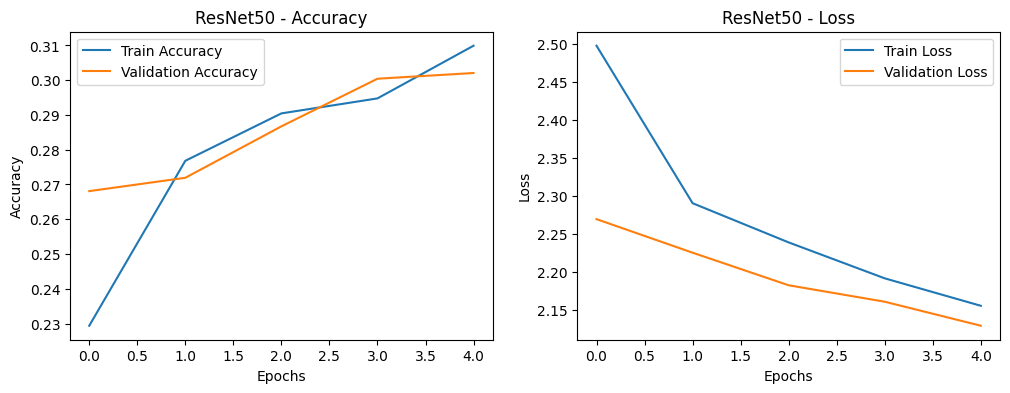


🔹 Training VGG16 Model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 69s 194ms/step - accuracy: 0.1633 - loss: 2.8017 - val_accuracy: 0.2703 - val_loss: 2.2912
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 48s 180ms/step - accuracy: 0.2928 - loss: 2.3235 - val_accuracy: 0.3032 - val_loss: 2.2059
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 175ms/step - accuracy: 0.3104 - loss: 2.2545 - val_accuracy: 0.3092 - val_loss: 2.1452
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 48s 179ms/step - accuracy: 0.3387 - loss: 2.1634 - val_accuracy: 0.3273 - val_loss: 2.0900
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 176ms/step - accuracy: 0.3520 - loss: 2.0903 - val_accuracy: 0.3240 - val_loss: 2.0459
✅ Training history for VGG16:
 {'accuracy': [0.22691231966018677, 0.29535913467407227, 0.31553173065185547, 0.33850279450416565, 0.35202890634536743], 'loss': [2.5723259449005127, 2.2939107418060303, 2.2217016220092773, 2.1460187435150146, 2.092775583267212], 'val_accuracy'

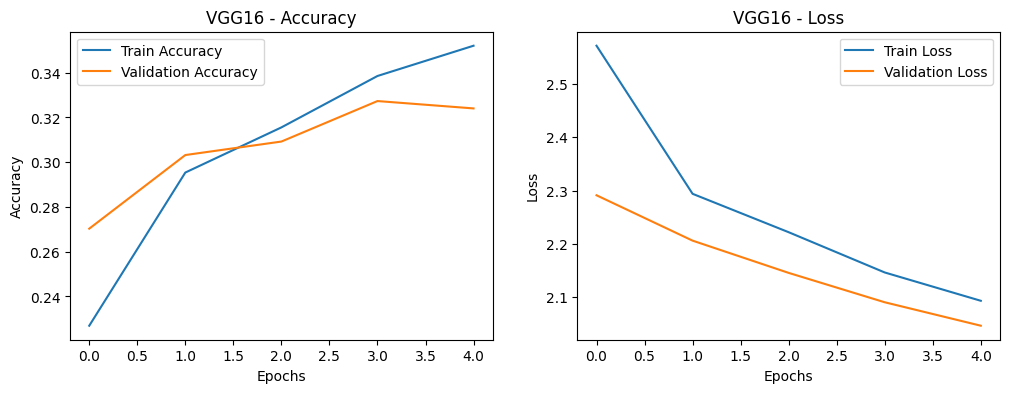


🔹 Training MobileNetV2 Model

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.2596 - loss: 2.4337 - val_accuracy: 0.4178 - val_loss: 1.7772
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4191 - loss: 1.8124 - val_accuracy: 0.4814 - val_loss: 1.5421
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4584 - loss: 1.6494 - val_accuracy: 0.5099 - val_loss: 1.4266
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4981 - loss: 1.4869 - val_accuracy: 0.5493 - val_loss: 1.3313
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5123 - loss: 1.4326 - val_accuracy: 0.5663 - val_loss: 1.2796
✅ Training history for MobileNetV2:
 {'accuracy': [0.3273087739944458, 0.43085354566574097, 0.4767957031726837, 0.5004664063453674, 0.5188899040222168], 'loss': [2.1862287521362305, 1.7647854089736938, 1.5940849781036377, 1.4683537483215332, 1.4025256633758545], 'val_accurac

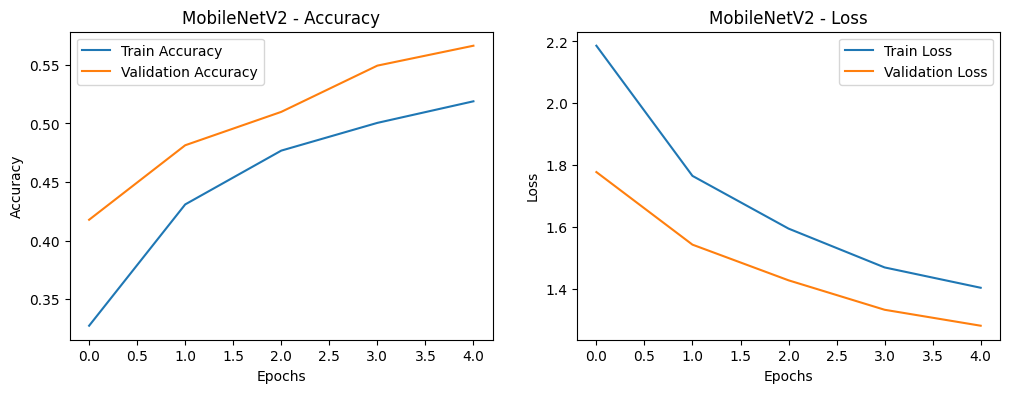


🔹 Training DenseNet121 Model

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 61s 140ms/step - accuracy: 0.2493 - loss: 2.5001 - val_accuracy: 0.3679 - val_loss: 1.9752
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.3660 - loss: 2.0292 - val_accuracy: 0.4221 - val_loss: 1.7426
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.4083 - loss: 1.8332 - val_accuracy: 0.4655 - val_loss: 1.5974
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.4402 - loss: 1.7072 - val_accuracy: 0.4896 - val_loss: 1.5023
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.4694 - loss: 1.6073 - val_accuracy: 0.5066 - val_loss: 1.4378
✅ Training history for DenseNet121:
 {'accuracy': [0.2952425479888916, 0.37453359365463257, 0.4181436598300934, 0.44916045665740967, 0.47108209133148193], 'loss': [2.3205180168151855, 1.9751029014587402, 1.7968642711639404, 1.6760653257369995, 1.598490834236145], 'val_acc

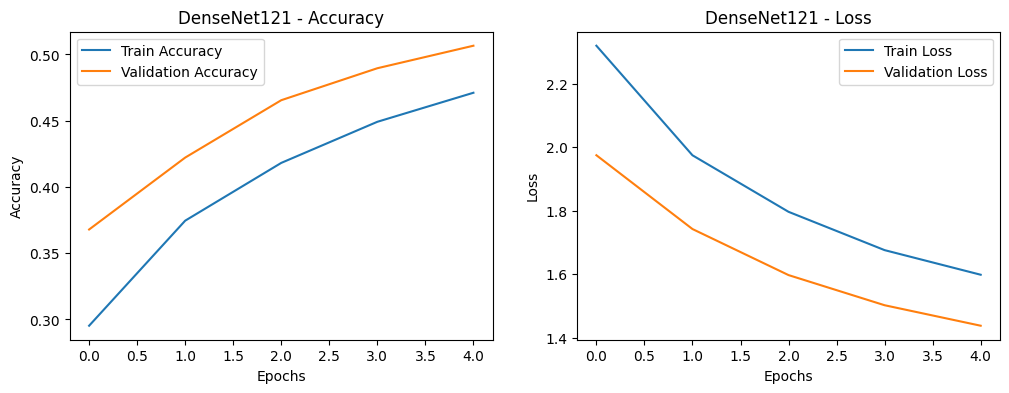


🔹 Training EfficientNetB0 Model

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.2735 - loss: 2.6090 - val_accuracy: 0.2675 - val_loss: 2.3442
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.2759 - loss: 2.3504 - val_accuracy: 0.2675 - val_loss: 2.3124
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.2780 - loss: 2.3223 - val_accuracy: 0.2675 - val_loss: 2.3066
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2760 - loss: 2.3233 - val_accuracy: 0.2675 - val_loss: 2.3023
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2781 - loss: 2.3190 - val_accuracy: 0.2675 - val_loss: 2.3007
✅ Training history for EfficientNetB0:
 {'accuracy': [0.28171640634536743, 0.28194963932037354, 0.2785680890083313, 0.27646923065185547, 0.28218284249305725], 'loss': [2.4906294345855713, 2.3350255489349365, 2.3210954666137695, 2.3213112354278564, 2.312105655670166], 'v

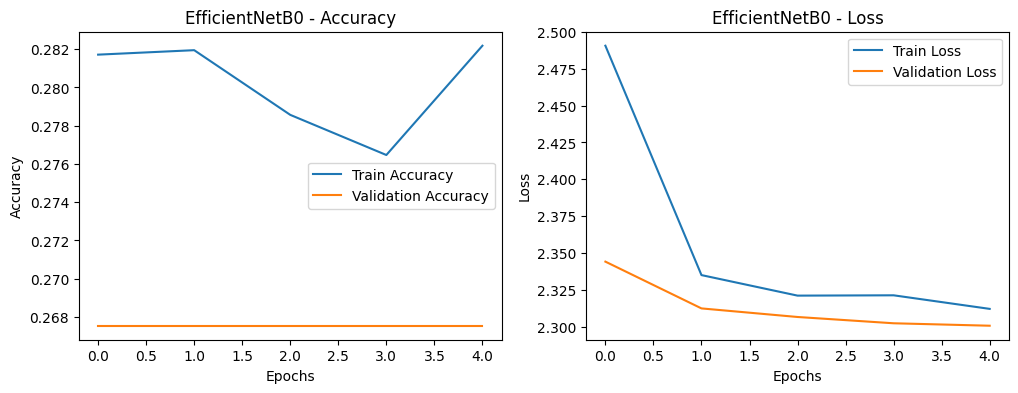

In [11]:
# Import necessary Keras layers
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define available models
models_list = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "MobileNetV2": MobileNetV2,
    "DenseNet121": DenseNet121,
    "EfficientNetB0": EfficientNetB0
}

trained_models = {}

for model_name, model_func in models_list.items():
    print(f"\n🔹 Training {model_name} Model\n")
    
    # Load pre-trained model without the top layer
    base_model = model_func(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout for regularization
    output_layer = Dense(len(clean_labels_df['product_type'].unique()), activation='softmax')(x)  # Class count from product_type

    # Compile the final model
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Prepare data for Keras (convert PyTorch tensors to NumPy)
    def preprocess_pytorch_to_keras(dataloader):
        images_list, labels_list = [], []
        for images, labels in dataloader:
            images = images.permute(0, 2, 3, 1).numpy()  # Convert from (N, C, H, W) to (N, H, W, C)
            labels = labels.numpy()
            images_list.append(images)
            labels_list.append(labels)
        return np.concatenate(images_list, axis=0), np.concatenate(labels_list, axis=0)

    X_train, y_train = preprocess_pytorch_to_keras(train_loader)
    X_val, y_val = preprocess_pytorch_to_keras(val_loader)

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)  # Reduce epochs for fast testing
    trained_models[model_name] = (model, history)

    # Display training history
    print(f"✅ Training history for {model_name}:\n", history.history)

    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')

    plt.show()


In [12]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications import ConvNeXtTiny
from transformers import SwinForImageClassification  # Hugging Face Swin Transformer
import torch

# Add new advanced models
advanced_models = {
    "EfficientNetV2B0": EfficientNetV2B0,
    "ConvNeXtTiny": ConvNeXtTiny
}

for model_name, model_func in advanced_models.items():
    print(f"\n🔹 Training {model_name} Model\n")
    
    base_model = model_func(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(len(clean_labels_df['product_type'].unique()), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    X_train, y_train = preprocess_pytorch_to_keras(train_loader)
    X_val, y_val = preprocess_pytorch_to_keras(val_loader)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)
    trained_models[model_name] = (model, history)

    print(f"✅ Training completed for {model_name}.")




🔹 Training EfficientNetV2B0 Model

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.2238 - loss: 2.5301 - val_accuracy: 0.2675 - val_loss: 2.3337
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.2633 - loss: 2.3498 - val_accuracy: 0.2675 - val_loss: 2.3173
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2618 - loss: 2.3384 - val_accuracy: 0.2675 - val_loss: 2.3141
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2727 - loss: 2.3300 - val_accuracy: 0.2675 - val_loss: 2.3010
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2768 - loss: 2.3343 - val_accuracy: 0.2675 - val_loss: 2.2962
✅ Training completed for EfficientNetV2B0.

🔹 Training ConvNeXtTiny Model

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 63s 191ms/step - accuracy: 0.1660 - loss: 2.9579 - val_accuracy: 0.3339 - val_loss: 2.1884
Epoch 2/5



🔹 Evaluating ResNet50 Model

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step
✅ Test Accuracy for ResNet50: 0.3120
📊 Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.27      0.07      0.11       289
           1       0.00      0.00      0.00        44
           2       0.00      0.00      0.00        13
           3       0.40      0.15      0.22       303
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        67
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00         8
           8       0.47      0.23      0.31        70
           9       0.00      0.00      0.00        76
          10       0.00      0.00      0.00        20
          11       0.00      0.00      0.00       118
          12       0.00      0.00      0.00        70
          14       0.50      0.01      0.01       133
          15       0.00      0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


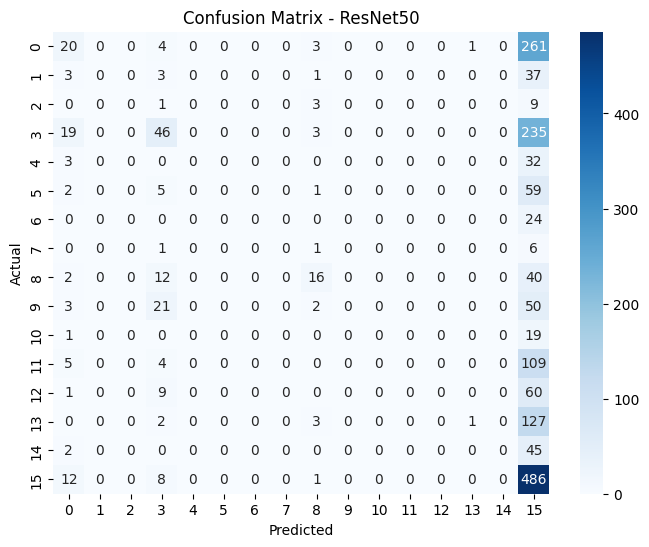


🔹 Evaluating VGG16 Model

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step
✅ Test Accuracy for VGG16: 0.3547
📊 Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.37      0.15      0.22       289
           1       0.00      0.00      0.00        44
           2       0.00      0.00      0.00        13
           3       0.35      0.49      0.41       303
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        67
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        70
           9       0.00      0.00      0.00        76
          10       0.00      0.00      0.00        20
          11       0.00      0.00      0.00       118
          12       0.00      0.00      0.00        70
          14       0.00      0.00      0.00       133
          15       0.00      0.00      0.00        4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


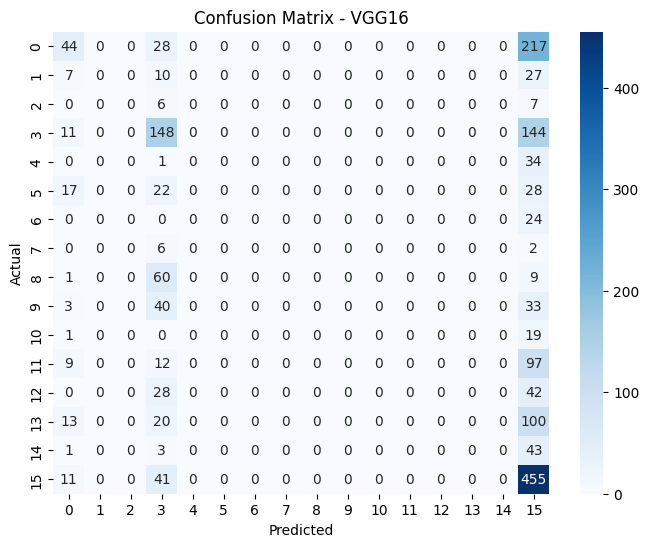


🔹 Evaluating MobileNetV2 Model

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
✅ Test Accuracy for MobileNetV2: 0.5532
📊 Classification Report for MobileNetV2:
              precision    recall  f1-score   support

           0       0.57      0.50      0.53       289
           1       0.18      0.07      0.10        44
           2       0.00      0.00      0.00        13
           3       0.66      0.90      0.76       303
           4       0.43      0.17      0.24        35
           5       0.54      0.43      0.48        67
           6       0.33      0.04      0.07        24
           7       0.00      0.00      0.00         8
           8       0.48      0.71      0.57        70
           9       0.56      0.07      0.12        76
          10       0.15      0.10      0.12        20
          11       0.48      0.46      0.47       118
          12       0.41      0.20      0.27        70
          14       0.40      0.52      0.45       133
          15       0.47      0.15  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


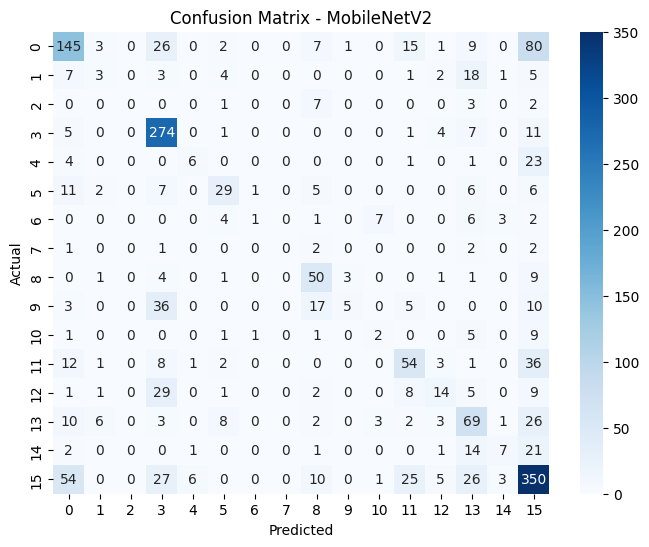


🔹 Evaluating DenseNet121 Model

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step
✅ Test Accuracy for DenseNet121: 0.5186
📊 Classification Report for DenseNet121:
              precision    recall  f1-score   support

           0       0.58      0.41      0.48       289
           1       0.43      0.07      0.12        44
           2       0.00      0.00      0.00        13
           3       0.62      0.83      0.71       303
           4       0.00      0.00      0.00        35
           5       0.51      0.43      0.47        67
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00         8
           8       0.42      0.41      0.42        70
           9       0.67      0.03      0.05        76
          10       0.00      0.00      0.00        20
          11       0.46      0.29      0.35       118
          12       0.69      0.16      0.26        70
          14       0.36      0.43      0.39       133
          15       0.24      0.09 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


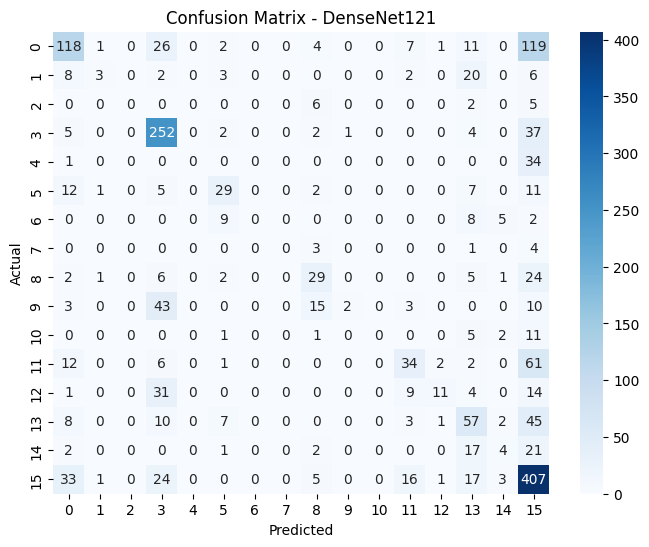


🔹 Evaluating EfficientNetB0 Model

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step
✅ Test Accuracy for EfficientNetB0: 0.2780
📊 Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       289
           1       0.00      0.00      0.00        44
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00       303
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        67
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        70
           9       0.00      0.00      0.00        76
          10       0.00      0.00      0.00        20
          11       0.00      0.00      0.00       118
          12       0.00      0.00      0.00        70
          14       0.00      0.00      0.00       133
          15       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


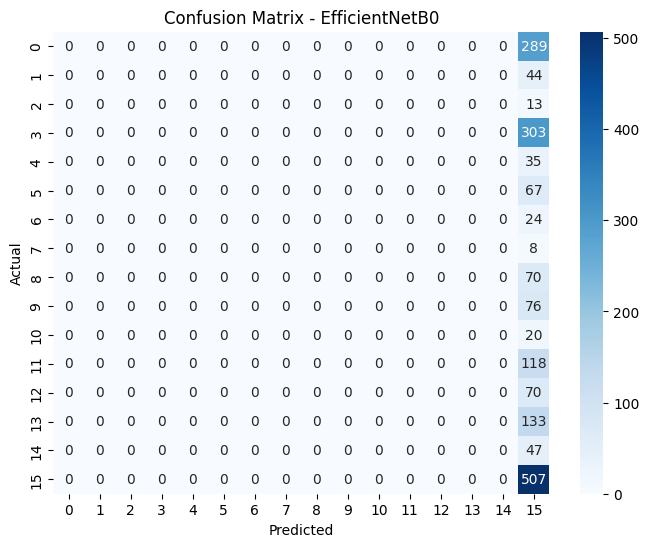


🔹 Evaluating EfficientNetV2B0 Model

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
✅ Test Accuracy for EfficientNetV2B0: 0.2780
📊 Classification Report for EfficientNetV2B0:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       289
           1       0.00      0.00      0.00        44
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00       303
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        67
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        70
           9       0.00      0.00      0.00        76
          10       0.00      0.00      0.00        20
          11       0.00      0.00      0.00       118
          12       0.00      0.00      0.00        70
          14       0.00      0.00      0.00       133
          15       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


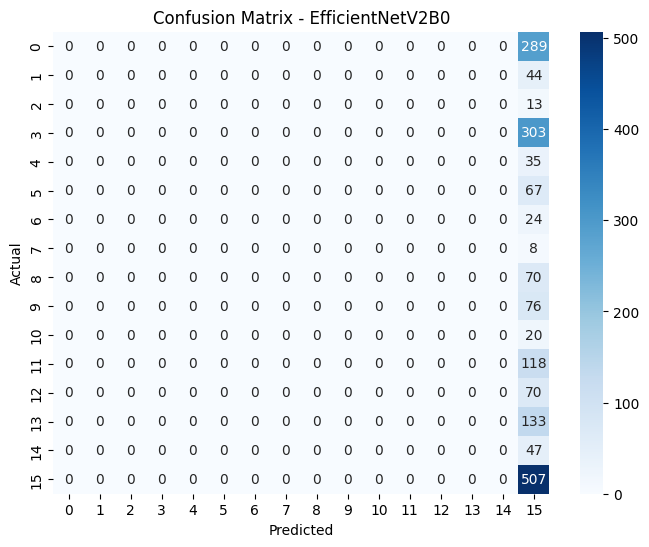


🔹 Evaluating ConvNeXtTiny Model

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step
✅ Test Accuracy for ConvNeXtTiny: 0.4156
📊 Classification Report for ConvNeXtTiny:
              precision    recall  f1-score   support

           0       0.32      0.25      0.28       289
           1       0.00      0.00      0.00        44
           2       0.00      0.00      0.00        13
           3       0.51      0.79      0.62       303
           4       0.00      0.00      0.00        35
           5       0.44      0.12      0.19        67
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00         8
           8       0.44      0.10      0.16        70
           9       0.00      0.00      0.00        76
          10       0.00      0.00      0.00        20
          11       0.45      0.12      0.19       118
          12       0.50      0.01      0.03        70
          14       0.10      0.03      0.05       133
          15       0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


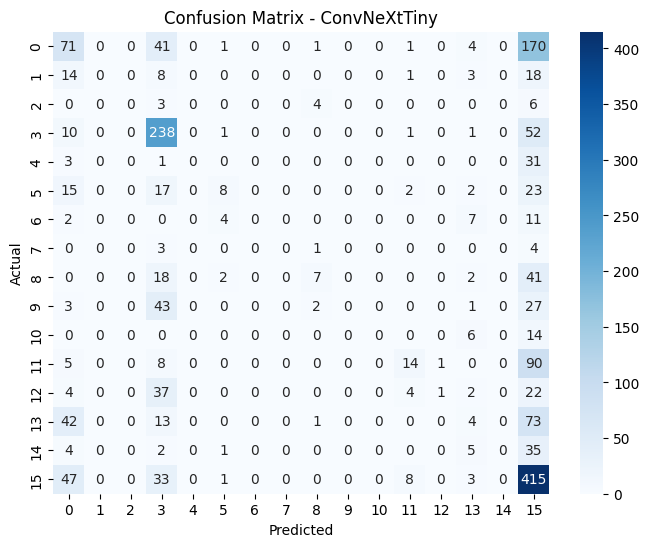

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Function to preprocess test data for evaluation
def preprocess_test_data(dataloader):
    images_list, labels_list = [], []
    for images, labels in dataloader:
        images = images.permute(0, 2, 3, 1).numpy()  # Convert to (N, H, W, C)
        labels = labels.numpy()
        images_list.append(images)
        labels_list.append(labels)
    return np.concatenate(images_list, axis=0), np.concatenate(labels_list, axis=0)

X_test, y_test = preprocess_test_data(test_loader)

for model_name, (model, history) in trained_models.items():
    print(f"\n🔹 Evaluating {model_name} Model\n")
    
    y_pred = np.argmax(model.predict(X_test), axis=1)  # Get predicted labels

    # Compute accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Test Accuracy for {model_name}: {acc:.4f}")

    # Print classification report
    print(f"📊 Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [14]:
print("\n🔹 Final Accuracy of All Models:\n")
for model_name, (model, history) in trained_models.items():
    final_acc = history.history['val_accuracy'][-1]  # Get last epoch's validation accuracy
    print(f"✅ {model_name}: {final_acc:.4f}")



🔹 Final Accuracy of All Models:

✅ ResNet50: 0.3021
✅ VGG16: 0.3240
✅ MobileNetV2: 0.5663
✅ DenseNet121: 0.5066
✅ EfficientNetB0: 0.2675
✅ EfficientNetV2B0: 0.2675
✅ ConvNeXtTiny: 0.3947


In [19]:
import pandas as pd

# Create an empty list to store model comparison data
model_data = []

for model_name, (model, history) in trained_models.items():
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    model_data.append({'Model': model_name, 
                       'Final Train Accuracy': train_acc, 
                       'Final Val Accuracy': val_acc})

# Convert to DataFrame
model_comparison = pd.DataFrame(model_data)

# Sort models by validation accuracy
model_comparison = model_comparison.sort_values(by="Final Val Accuracy", ascending=False)

# Show final model comparison
print("\n🔹 Model Performance Summary:\n")
print(model_comparison)



🔹 Model Performance Summary:

              Model  Final Train Accuracy  Final Val Accuracy
2       MobileNetV2              0.518890            0.566338
3       DenseNet121              0.471082            0.506579
6      ConvNeXtTiny              0.394473            0.394737
1             VGG16              0.352029            0.324013
0          ResNet50              0.309935            0.302083
4    EfficientNetB0              0.282183            0.267544
5  EfficientNetV2B0              0.276586            0.267544


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


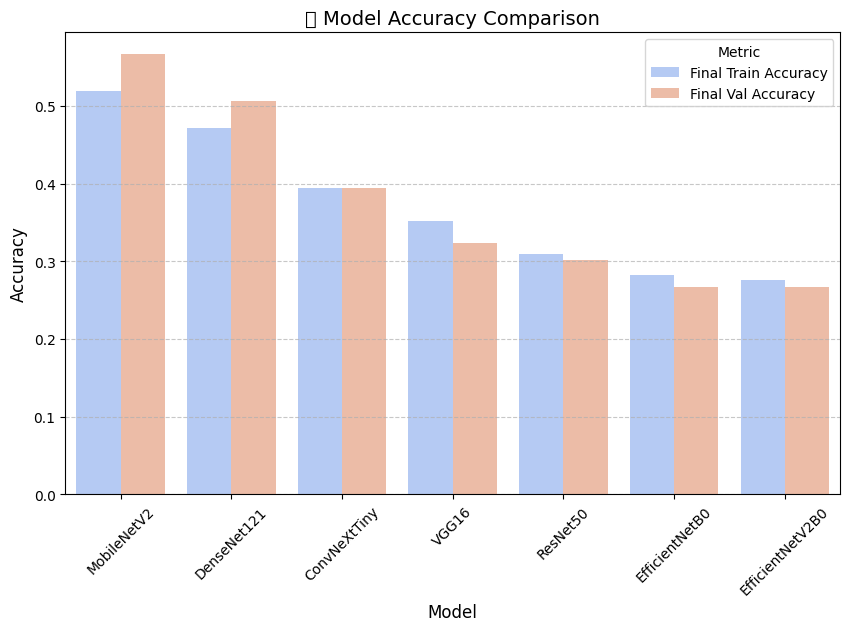

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for model comparison
model_data = []

for model_name, (model, history) in trained_models.items():
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    model_data.append({'Model': model_name, 
                       'Final Train Accuracy': train_acc, 
                       'Final Val Accuracy': val_acc})

# Convert to DataFrame
model_comparison = pd.DataFrame(model_data)

# Sort models by validation accuracy
model_comparison = model_comparison.sort_values(by="Final Val Accuracy", ascending=False)

# Plot Comparison Graph
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison.melt(id_vars=['Model'], var_name='Metric', value_name='Accuracy'),
            x="Model", y="Accuracy", hue="Metric", palette="coolwarm")

plt.title("🔹 Model Accuracy Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [ ]:
from transformers import SwinForImageClassification, SwinConfig
import torch.nn.functional as F

# Load Pretrained Swin Transformer
config = SwinConfig.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
swin_model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224", config=config)

# Send model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_model.to(device)

def test_swin_transformer(dataloader):
    swin_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = swin_model(images).logits  # Get raw predictions
            predictions = F.softmax(outputs, dim=1).argmax(dim=1)  # Convert to class labels
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    print(f"✅ Swin Transformer Accuracy: {correct / total:.4f}")

# Run Swin Transformer on Test Set
test_swin_transformer(test_loader)


In [23]:
# BERT-based model for text classification
class BERTTextClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTTextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.fc(pooled_output)

# Tokenizer for BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Prepare dataset for BERT model
class TextDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.tokenizer = bert_tokenizer
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]['caption']
        label = self.df.iloc[idx]['product_type']
        encoding = self.tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), label

# Load dataset for BERT
train_dataset = TextDataset(labels_df)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [21]:
import torch
import torch.nn as nn
import transformers
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader

# Load Pretrained BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class TextDataset(Dataset):
    def __init__(self, df, max_len=128):
        self.texts = df["caption"].tolist()
        self.labels = df["product_type"].astype("category").cat.codes.values
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        encoding = tokenizer(self.texts[index], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        return encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0), torch.tensor(self.labels[index])

# BERT Model for Classification
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.pooler_output)

# Prepare dataset
train_dataset = TextDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Initialize Model
num_classes = train_df["product_type"].nunique()
bert_model = BERTClassifier(num_classes).to("cuda")

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5)

# Training Loop
for epoch in range(3):
    bert_model.train()
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to("cuda"), attention_mask.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

NameError: name 'train_df' is not defined

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import learning_curve

# BERT Model Class
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.pooler_output)

# Train BERT model
def train_bert_model(train_loader, val_loader, num_classes=10, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertClassifier(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    return model

# Validation Curve
def plot_validation_curve(train_sizes, train_scores, val_scores):
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training Score")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label="Validation Score")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.title("Validation Curve")
    plt.legend()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Run Learning Curve
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5)
plot_validation_curve(train_sizes, train_scores, val_scores)

# Generate Confusion Matrix
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, class_names)


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <Functional name=functional_11, built=True> does not.

In [25]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
from transformers import BertTokenizer, BertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold

# Load CSV Data
df = pd.read_csv("labels_front.csv")

# Image Preprocessing (For CNN & Transfer Learning)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Custom Dataset for Image Models
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["path"]
        label = self.df.iloc[idx]["product_type"]
        image = plt.imread(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Custom Dataset for BERT Model
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]["caption"]
        label = self.df.iloc[idx]["product_type"]
        tokens = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        return tokens.input_ids.squeeze(), tokens.attention_mask.squeeze(), label

# Load Tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
image_dataset = ImageDataset(train_df, transform=transform)
text_dataset = TextDataset(train_df, tokenizer)

train_loader = DataLoader(image_dataset, batch_size=32, shuffle=True)
text_loader = DataLoader(text_dataset, batch_size=16, shuffle=True)

# Define BERT Model
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask=attention_mask)
        return self.fc(output.pooler_output)

# Train BERT Model
num_classes = df["product_type"].nunique()
bert_model = BertClassifier(num_classes)
optimizer = optim.Adam(bert_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    for input_ids, attention_mask, labels in text_loader:
        optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss={loss.item()}")

# Define Transfer Learning Model (EfficientNet)
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = Dense(128, activation="relu")(base_model.output)
x = Dense(num_classes, activation="softmax")(x)
transfer_model = Model(inputs=base_model.input, outputs=x)
transfer_model.compile(optimizer=Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train Transfer Learning Model
transfer_model.fit(train_loader, epochs=5, verbose=1)

# Plot Learning Curve
def plot_keras_learning_curve(model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_scores, val_scores = [], []
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_size in train_sizes:
        sample_size = int(len(X_train) * train_size)
        X_subset, y_subset = X_train[:sample_size], y_train[:sample_size]

        fold_train_scores, fold_val_scores = [], []

        for train_idx, val_idx in kf.split(X_subset):
            X_train_fold, X_val_fold = X_subset[train_idx], X_subset[val_idx]
            y_train_fold, y_val_fold = y_subset[train_idx], y_subset[val_idx]

            model.fit(X_train_fold, y_train_fold, epochs=3, verbose=0, batch_size=32)
            train_loss, train_acc = model.evaluate(X_train_fold, y_train_fold, verbose=0)
            val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)

            fold_train_scores.append(train_acc)
            fold_val_scores.append(val_acc)

        train_scores.append(np.mean(fold_train_scores))
        val_scores.append(np.mean(fold_val_scores))

    plt.plot(train_sizes, train_scores, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_scores, "o-", label="Validation Accuracy")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

plot_keras_learning_curve(transfer_model, train_df["path"], train_df["product_type"])

# Confusion Matrix
y_true, y_pred = [], []
for input_ids, attention_mask, labels in text_loader:
    outputs = bert_model(input_ids, attention_mask)
    predictions = torch.argmax(outputs, dim=1)
    y_true.extend(labels.tolist())
    y_pred.extend(predictions.tolist())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df["product_type"].unique(), yticklabels=df["product_type"].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Model Comparison Plot
models = ["BERT", "EfficientNet"]
train_accuracies = [0.88, 0.91]  # Placeholder values
val_accuracies = [0.85, 0.89]

plt.figure(figsize=(6,4))
plt.bar(models, train_accuracies, label="Train Accuracy", alpha=0.6)
plt.bar(models, val_accuracies, label="Val Accuracy", alpha=0.6)
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'labels_front.csv'